In [1]:
import pickle
import torch.nn as nn
import torchmetrics
import pandas as pd
import torch
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import transformers
from transformers import AutoModel
import random
from sklearn.model_selection import GroupShuffleSplit
import sklearn
import time
from collections import defaultdict
from datetime import datetime
import re
from collections import Counter
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans

c:\Users\wicto\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [4]:
with open("../data/190325_data.pkl", "rb") as f:
    chat_data = pickle.load(f)
    
# Remove service chat
del chat_data[-1000]

In [5]:
for i in range(3):
    game_id = random.choice(list(chat_data.keys()))
    while len(list(chat_data[game_id]['messages'])) == 0:
        game_id = random.choice(list(chat_data.keys()))
        
    message = random.choice(list(chat_data[game_id]['messages']))
    while message["userID"] == "GameMaster":
        message = random.choice(list(chat_data[game_id]['messages']))

    print(message)

{'gameID': 3750, 'oldidx': None, 'color': 'Blue', 'userID': 'OxIok9CEdREUMZkK', 'botID': 0, 'message': 'hi', 'create_time': datetime.datetime(2025, 1, 30, 8, 41, 2), 'colorID': 'blue400', 'messageidx': 23847}
{'gameID': 2612, 'oldidx': None, 'color': 'Yellow', 'userID': 'e3e486gOkMJ60vsN', 'botID': 0, 'message': 'hi everyone even the machine', 'create_time': datetime.datetime(2024, 9, 6, 13, 6, 20), 'colorID': 'yellow400', 'messageidx': 9810}
{'gameID': 2349, 'oldidx': None, 'color': 'Blue', 'userID': '0', 'botID': 1, 'message': 'was ist denn das für ein Ding? wie geht das Spiel eigentlich weiter?', 'create_time': datetime.datetime(2024, 9, 5, 14, 46, 19), 'colorID': 'blue400', 'messageidx': 5894}


In [7]:
messages = []
labels = []
game_ids = []
user_ids = []
languages = []
for game_id, game_data in chat_data.items():
    for message in game_data["messages"]:
        if message["userID"] == "GameMaster":
            if "won" in message["message"] or "surrendered" in message["message"] or "canceled" in message["message"] or "lost" in message["message"] or "timed out" in message["message"] or "disconnected" in message["message"]:
                break
            else:
                continue
        messages.append(message["message"])
        labels.append([int(not message["botID"]), message["botID"]])
        game_ids.append(message["gameID"])
        user_ids.append(message["userID"])
        if game_data["language"] is None:
            languages.append("en")
        else:
            languages.append(game_data["language"])
        
print(len(messages))
print(len(labels))

22696
22696


In [6]:
messages_by_humans = 0
messages_by_bots = 0
for label in labels:
    if label[0] == 1:
        messages_by_humans += 1
    else:
        messages_by_bots += 1
print(messages_by_humans + messages_by_bots)

22696


In [7]:
sumation = 0
for message in messages:
    sumation += len(message.split(" "))
print(f"Sum of all words: {sumation}")
print(f"Average length of a message: {sumation/len(messages):.2f}")

Sum of all words: 121020
Average length of a message: 5.33


In [8]:
word_counts = [len(message.split()) for message in messages]
word_counts.sort()

n = len(word_counts)
if n % 2 == 1:
    median = word_counts[n // 2]
else:
    median = (word_counts[n // 2 - 1] + word_counts[n // 2]) / 2

print(f"Median word count: {median}")
print(f"Shortest message: {min(word_counts)}")
print(f"Longest message: {max(word_counts)}")

Median word count: 4.0
Shortest message: 0
Longest message: 46


In [13]:
unsorted_word_counts = [len(message.split()) for message in messages]
print(messages[np.argmax(unsorted_word_counts)])
print(game_ids[np.argmax(unsorted_word_counts)])

its realy complicated, but basicly its a hash of the cd key and the bios info, then they used some crazy math to get the product key, dont think i can explain it beter, im a cs student but thats way to low level 4 me
2331


In [14]:
char_counts = np.array([len(m.replace(" ", "")) for m in messages])

average = np.mean(char_counts)
std_dev = np.std(char_counts, ddof=1)

print(f"Average: {average:.2f}, Standard Deviation: {std_dev:.2f}")

Average: 22.51, Standard Deviation: 20.11


In [15]:
print(f"Messages by humans: {messages_by_humans}")
print(f"Messages by bots: {messages_by_bots}")
print(f"Percent by humans: {messages_by_humans/len(labels)*100:.2f}")
print(f"Percent by bots: {messages_by_bots/len(labels)*100:.2f}")
print(f"Number of games: {len(chat_data.keys())}")

Messages by humans: 15753
Messages by bots: 6943
Percent by humans: 69.41
Percent by bots: 30.59
Number of games: 1559


In [16]:
english_messages = 0
german_messages = 0
for game_id, game_data in chat_data.items():
    m= []
    for message in game_data["messages"]:
        if message["userID"] == "GameMaster":
            if "won" in message["message"] or "surrendered" in message["message"] or "canceled" in message["message"] or "lost" in message["message"] or "timed out" in message["message"] or "disconnected" in message["message"]:
                break
            else:
                continue
        m.append(message["message"])
    if game_data["language"] == "en":
        english_messages += len(m)
    if game_data["language"] == "de":
        german_messages += len(m)
print(f"Number of messages in german games: {german_messages}")
print(f"Number of messages in english games: {english_messages}")

Number of messages in german games: 9139
Number of messages in english games: 13070


In [17]:
english_words = []
german_words = []

for message, lang in zip(messages, languages):
    words = re.findall(r'\b\w+\b', message.lower())

    if lang == "en":
        english_words.extend(words)
    elif lang == "de":
        german_words.extend(words)

english_common = Counter(english_words).most_common(10)
german_common = Counter(german_words).most_common(10)

print("Most common English words:", english_common)
print("Most common German words:", german_common)

Most common English words: [('you', 2615), ('i', 2418), ('the', 1842), ('a', 1269), ('is', 1250), ('what', 1226), ('to', 1126), ('are', 1075), ('blue', 899), ('yellow', 874)]
Most common German words: [('ich', 2131), ('du', 1170), ('wie', 1057), ('ist', 1014), ('hallo', 918), ('was', 823), ('das', 750), ('bin', 685), ('ihr', 615), ('nicht', 519)]


In [18]:
english_question_words = ["how", "where", "what", "why", "when", "who", "which", "whom", "does", "do", "is", "are", "can", "could", "would", "should"]
german_question_words = ["wie", "wo", "was", "warum", "wann", "wer", "welche", "wem", "ob", "ist", "sind", "kann", "könnte", "würde", "sollte"]

question_count = 0
english_question_count = 0
german_question_count = 0

english_messages = 0
german_messages = 0

for message, lang in zip(messages, languages):
    lower_msg = message.lower()

    if lang == "en":
        english_messages += 1
        if "?" in lower_msg or any(word in lower_msg for word in english_question_words):
            question_count += 1
            english_question_count += 1

    elif lang == "de":
        german_messages += 1
        if "?" in lower_msg or any(word in lower_msg for word in german_question_words):
            question_count += 1
            german_question_count += 1

total_messages = len(messages)

print(f"Number of questions asked: {question_count}")
print(f"Percentage of questions: {question_count / total_messages:.2%}")
print(f"English questions: {english_question_count} ({english_question_count / english_messages:.2%})")
print(f"German questions: {german_question_count} ({german_question_count / german_messages:.2%})")


Number of questions asked: 11501
Percentage of questions: 50.67%
English questions: 6896 (50.87%)
German questions: 4605 (50.39%)


In [24]:
english_question_words = ["how", "where", "what", "why", "when", "who", "which", "whom", "does", "do", "is", "are", "can", "could", "would", "should"]
german_question_words = ["wie", "wo", "was", "warum", "wann", "wer", "welche", "wem", "ob", "ist", "sind", "kann", "könnte", "würde", "sollte"]
question_words = english_question_words + german_question_words

question_count_human = 0
question_count_bot = 0
marked_question_count_bot = 0

human_message_count = 0
bot_message_count = 0
marked_question_count_human = 0

for message, user_id in zip(messages, user_ids):
    lower_msg = message.lower()

    if user_id[0] == "0":
        bot_message_count += 1
        if "?" in lower_msg or any(word in lower_msg for word in question_words):
            question_count_bot += 1
            if "?" in lower_msg:
                marked_question_count_bot += 1
    else:
        human_message_count += 1
        if "?" in lower_msg or any(word in lower_msg for word in question_words):
            question_count_human += 1
            if "?" in lower_msg:
                marked_question_count_human += 1

total_messages = len(messages)

print(f"Number of questions asked: {question_count_human + question_count_bot}")
print(f"Percentage of questions: {(question_count_bot + question_count_human) / total_messages:.2%}")
print(f"Bot questions: {question_count_bot} ({question_count_bot / bot_message_count:.2%})")
print(f"Bot questions ending in '?': {marked_question_count_bot} ({marked_question_count_bot / question_count_bot:.2%})")
print(f"Human questions: {question_count_human} ({question_count_human / human_message_count:.2%})")
print(f"Human questions ending in '?': {marked_question_count_human} ({marked_question_count_human / question_count_human:.2%})")


Number of questions asked: 12248
Percentage of questions: 53.97%
Bot questions: 4796 (67.54%)
Bot questions ending in '?': 3123 (65.12%)
Human questions: 7452 (47.78%)
Human questions ending in '?': 3457 (46.39%)


In [ ]:

total_time_diff = 0
total_message_pairs = 0
english_messages = 0
german_messages = 0

for game_id, game_data in chat_data.items():
    m = []
    game_over = False

    for message in game_data["messages"]:
        if game_over:
            break

        if message["userID"] == "GameMaster":
            if "won" in message["message"] or "surrendered" in message["message"] or "canceled" in message["message"] or "lost" in message["message"] or "timed out" in message["message"] or "disconnected" in message["message"]:
                game_over = True
                continue
            else:
                continue 

        m.append(message)

    if len(m) < 2:
        continue

    m.sort(key=lambda x: x["create_time"])

    if game_data["language"] == "en":
        english_messages += len(m)
    elif game_data["language"] == "de":
        german_messages += len(m)

    for i in range(1, len(m)):
        t1 = m[i - 1]["create_time"]
        t2 = m[i]["create_time"]
        delta = (t2 - t1).total_seconds()

        total_time_diff += delta
        total_message_pairs += 1


if total_message_pairs > 0:
    average_time_to_respond = total_time_diff / total_message_pairs
else:
    average_time_to_respond = 0

print(f"Number of messages in German games: {german_messages}")
print(f"Number of messages in English games: {english_messages}")
print(f"Average time between responses: {average_time_to_respond:.2f} seconds")

Number of messages in German games: 9131
Number of messages in English games: 13060
Average time between responses: 13.24 seconds


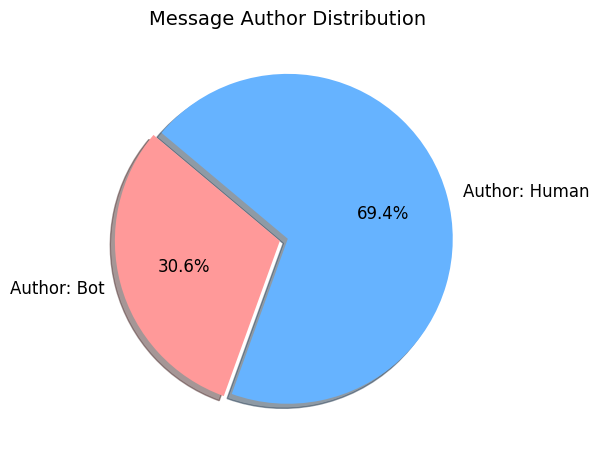

In [ ]:
labels = ["Author: Bot", "Author: Human"]
sizes = [messages_by_bots, messages_by_humans]
colors = ['#ff9999', '#66b3ff']
explode = (0.05, 0)

plt.figure(figsize=(6, 6))
plt.pie(sizes, 
        labels=labels, 
        colors=colors, 
        explode=explode,
        autopct='%1.1f%%',
        startangle=140,
        shadow=True,
        textprops={'fontsize': 12})

plt.title("Message Author Distribution", fontsize=14)
plt.tight_layout()
plt.show()

In [17]:
print(len(np.unique(np.array(user_ids))))

628


In [18]:
nique_values, counts = np.unique(np.array(user_ids), return_counts=True)

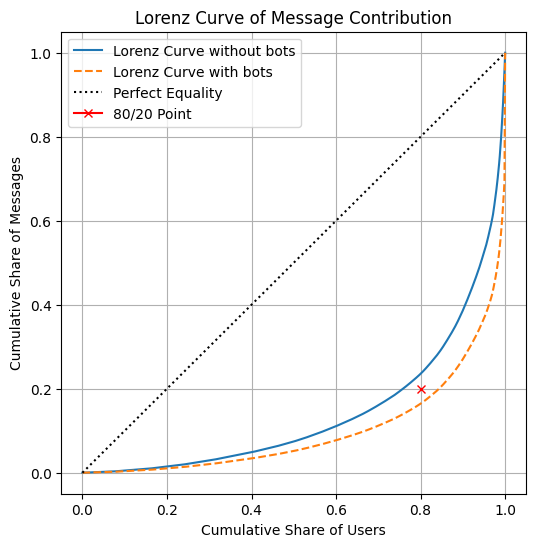

In [ ]:
def lorenz_curve(data):
    sorted_data = np.sort(np.array(data))
    cum_data = np.cumsum(sorted_data)
    return np.insert(cum_data / cum_data[-1], 0, 0), np.linspace(0, 1, len(cum_data)+1)

lorenz_y_all, lorenz_x_all = lorenz_curve(counts)
lorenz_y, lorenz_x = lorenz_curve(counts[1:])

plt.figure(figsize=(6, 6))
plt.plot(lorenz_x, lorenz_y, label='Lorenz Curve without bots')
plt.plot(lorenz_x_all, lorenz_y_all, label='Lorenz Curve with bots', linestyle='--')
plt.plot([0, 1], [0, 1], color='black', linestyle=':', label='Perfect Equality')

plt.plot(0.8, 0.2, marker='x', color='red', markersize=6, label='80/20 Point')

plt.xlabel("Cumulative Share of Users")
plt.ylabel("Cumulative Share of Messages")
plt.title("Lorenz Curve of Message Contribution")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
english_words = []
german_words = []

for message, lang in zip(messages, languages):
    words = re.findall(r'\b\w+\b', message.lower())

    if lang == "en":
        english_words.extend(words)
    elif lang == "de":
        german_words.extend(words)

english_common_50 = Counter(english_words).most_common(20)
german_common_50 = Counter(german_words).most_common(20)

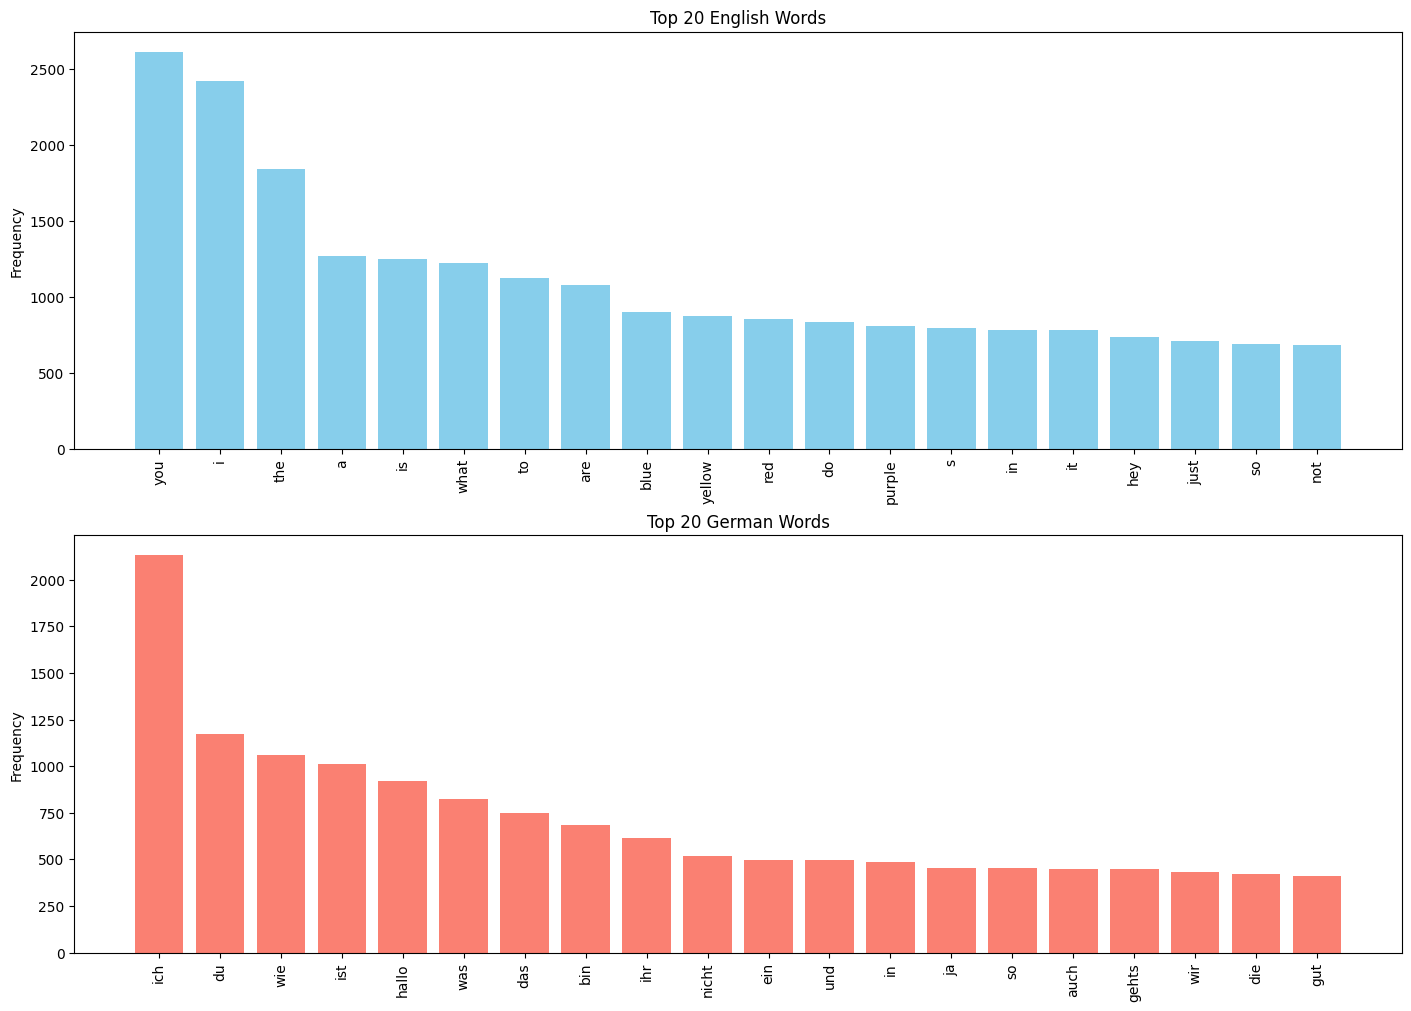

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import re

eng_words, eng_counts = zip(*english_common_50)
de_words, de_counts = zip(*german_common_50)

fig, axs = plt.subplots(2, 1, figsize=(14, 10), constrained_layout=True)

axs[0].bar(eng_words, eng_counts, color='skyblue')
axs[0].set_title('Top 20 English Words')
axs[0].set_ylabel('Frequency')
axs[0].tick_params(axis='x', rotation=90)

axs[1].bar(de_words, de_counts, color='salmon')
axs[1].set_title('Top 20 German Words')
axs[1].set_ylabel('Frequency')
axs[1].tick_params(axis='x', rotation=90)

plt.show()


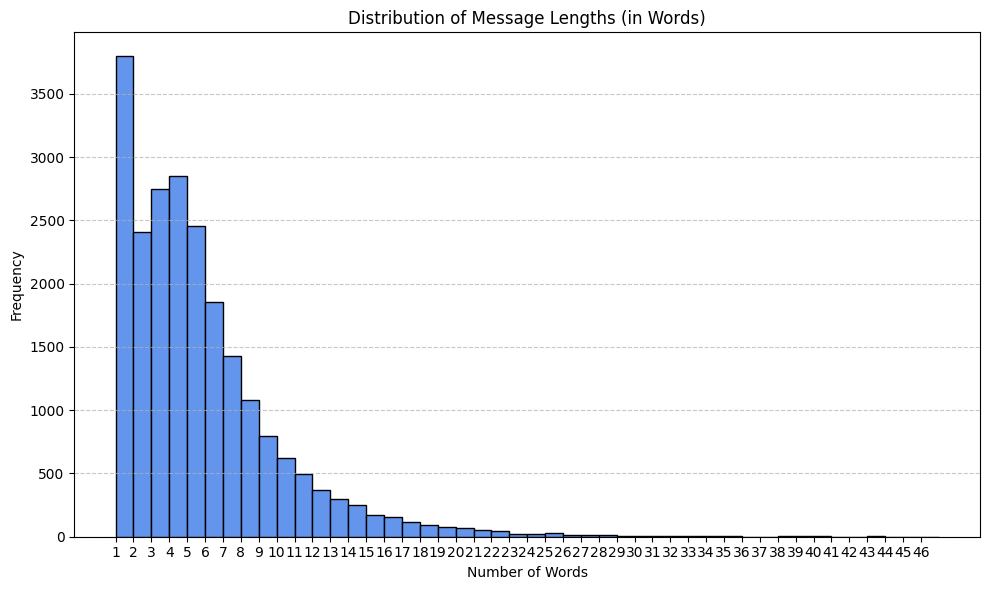

In [ ]:
message_lengths = [len(msg.split()) for msg in messages]

plt.figure(figsize=(10, 6))
plt.hist(message_lengths, bins=range(1, max(message_lengths)+2), edgecolor='black', color='cornflowerblue')
plt.title('Distribution of Message Lengths (in Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xticks(range(1, max(message_lengths)+1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



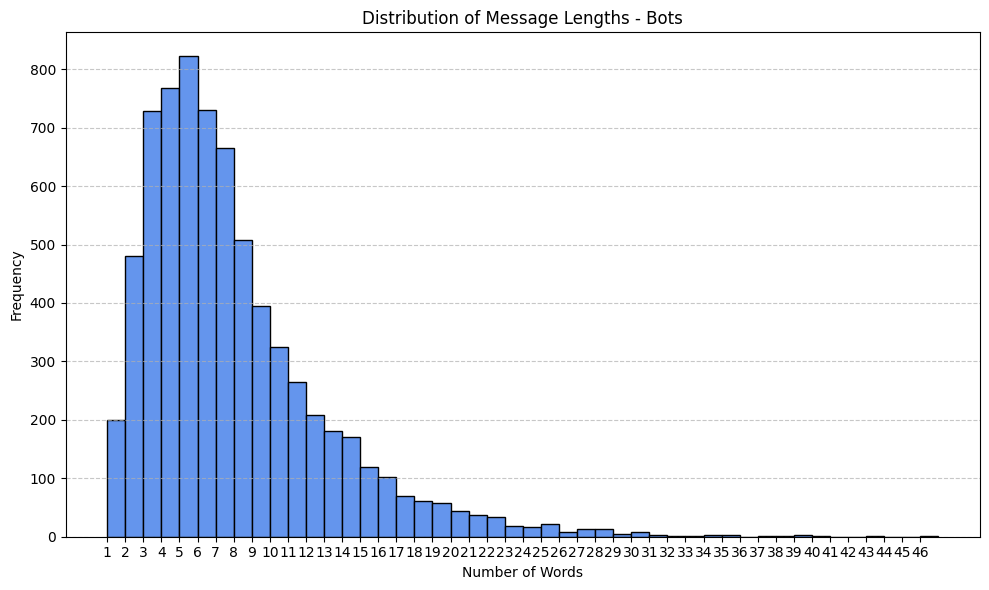

In [ ]:
message_lengths = [len(msg.split()) for msg, user_id in zip(messages, user_ids) if user_id[0]=='0']

plt.figure(figsize=(10, 6))
plt.hist(message_lengths, bins=range(1, max(message_lengths)+2), edgecolor='black', color='cornflowerblue')
plt.title('Distribution of Message Lengths - Bots')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xticks(range(1, max(message_lengths)+1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



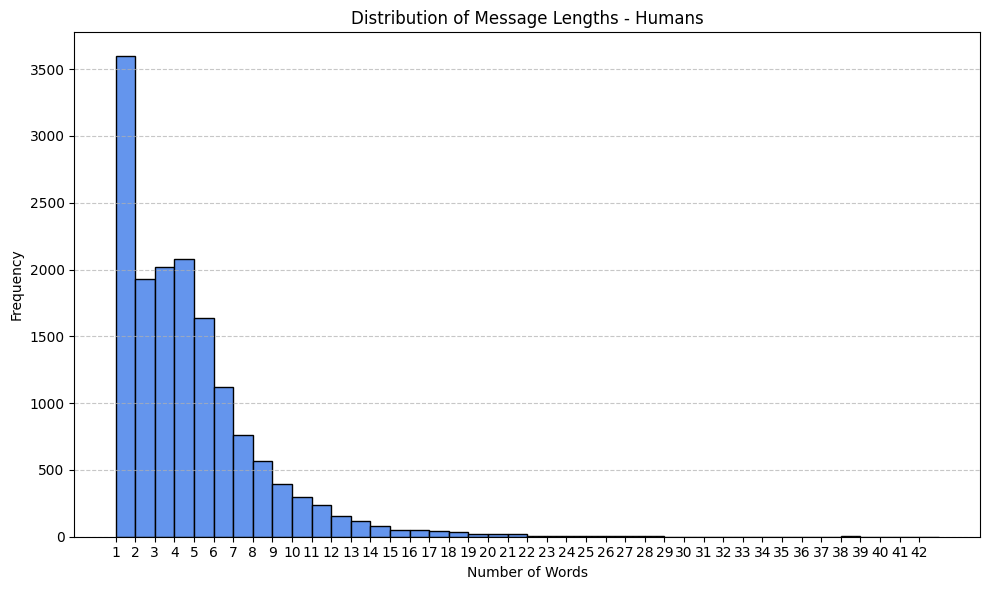

In [ ]:
message_lengths = [len(msg.split()) for msg, user_id in zip(messages, user_ids) if user_id[0]!='0']

plt.figure(figsize=(10, 6))
plt.hist(message_lengths, bins=range(1, max(message_lengths)+2), edgecolor='black', color='cornflowerblue')
plt.title('Distribution of Message Lengths - Humans')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xticks(range(1, max(message_lengths)+1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [29]:
s = pd.Series([len(msg.split()) for msg in messages])
s.describe()


count    22696.000000
mean         5.245990
std          4.384081
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         46.000000
dtype: float64

In [30]:
s = pd.Series([len(msg.split()) for msg, user_id in zip(messages, user_ids) if user_id[0]=='0'])
s.describe()

count    7101.000000
mean        7.505140
std         5.121442
min         1.000000
25%         4.000000
50%         6.000000
75%        10.000000
max        46.000000
dtype: float64

In [31]:
s = pd.Series([len(msg.split()) for msg, user_id in zip(messages, user_ids) if user_id[0]!='0'])
s.describe()

count    15595.000000
mean         4.217313
std          3.556381
min          0.000000
25%          1.500000
50%          3.000000
75%          6.000000
max         42.000000
dtype: float64

In [44]:
punctuation_list = ["?"]
print("Fraction of messages ending in punctuation for bots")
print(sum(1 if len(msg)>0 and msg[-1] in punctuation_list else 0 for msg, user_id in zip(messages, user_ids) if user_id[0]=='0')/sum(1 for msg, user_id in zip(messages, user_ids) if user_id[0]=='0'))

Fraction of messages ending in punctuation for bots
0.4207858048162231


In [45]:
print("Fraction of messages ending in punctuation for humans")
print(sum(1 if len(msg)>0 and msg[-1] in punctuation_list else 0 for msg, user_id in zip(messages, user_ids) if user_id[0]!='0')/sum(1 for msg, user_id in zip(messages, user_ids) if user_id[0]!='0'))

Fraction of messages ending in punctuation for humans
0.2026290477717217


In [34]:
with open('data/message_encodings.pkl', 'rb') as f:
    message_encodings = pickle.load(f)
with open('data/labels.pkl', 'rb') as f:
    labels = pickle.load(f)
print("Loaded data")

Loaded data


In [35]:
pca = sklearn.decomposition.PCA(n_components=2)
pca_X = pca.fit_transform(np.asarray(message_encodings))

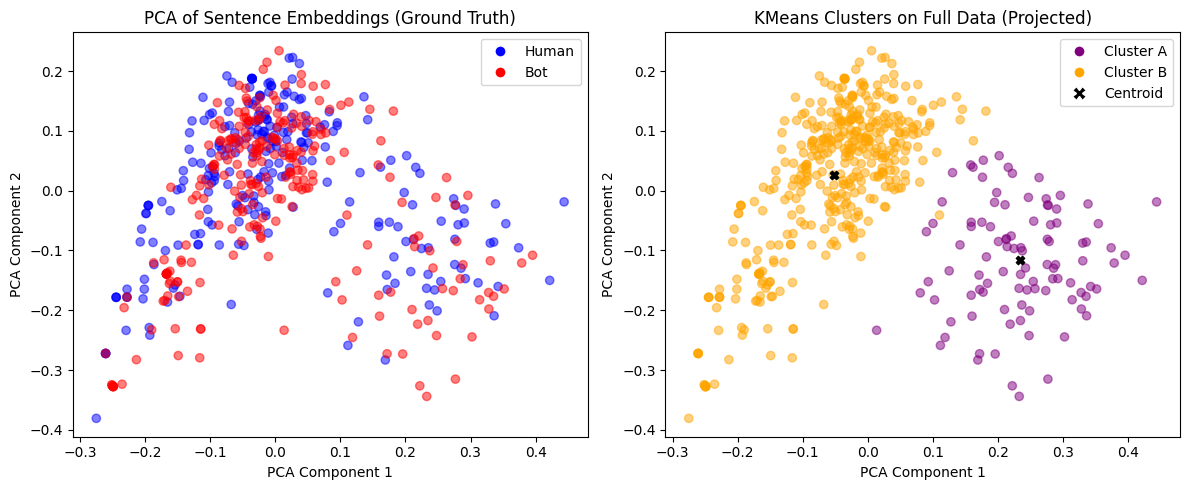

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

labels = np.array(labels)
n_points_per_class = 250

human_indices = np.where(np.all(labels == [1, 0], axis=1))[0]
bot_indices = np.where(np.all(labels == [0, 1], axis=1))[0]
np.random.shuffle(human_indices)
np.random.shuffle(bot_indices)
selected_indices = np.concatenate((human_indices[:n_points_per_class], bot_indices[:n_points_per_class]))

pca_points = pca_X[selected_indices]
pca_labels = labels[selected_indices]

full_vectors = message_encodings

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(full_vectors)

clusters_subset = kmeans.predict(full_vectors[selected_indices])

label_colors = np.array(["blue", "red"])
cluster_colors = np.array(["purple", "orange"])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(pca_points[:, 0], pca_points[:, 1],
                c=label_colors[pca_labels[:, 1]], alpha=0.5)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Human', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Bot', markerfacecolor='red', markersize=8)
]
axes[0].legend(handles=legend_elements)
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")
axes[0].set_title("PCA of Sentence Embeddings (Ground Truth)")

axes[1].scatter(pca_points[:, 0], pca_points[:, 1],
                c=cluster_colors[clusters_subset], alpha=0.5)

centroids_2d = pca.transform(kmeans.cluster_centers_)
axes[1].scatter(centroids_2d[:, 0], centroids_2d[:, 1],
                color='black', marker='X', label='Centroids')

axes[1].set_xlabel("PCA Component 1")
axes[1].set_ylabel("PCA Component 2")
axes[1].set_title("KMeans Clusters on Full Data (Projected)")

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Cluster A', markerfacecolor='purple', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Cluster B', markerfacecolor='orange', markersize=8),
    Line2D([0], [0], marker='X', color='w', label='Centroid', markerfacecolor='black', markersize=10)
]
axes[1].legend(handles=legend_elements)

plt.tight_layout()
plt.show()


In [38]:
messages_with_how_about_you= []
user_ids_with_how_about_you = []
messages_with_hbu = []
user_ids_with_hbu = []
for message, user_id in zip(messages, user_ids):
    if "how about you" in message:
        messages_with_how_about_you.append(message)
        user_ids_with_how_about_you.append(user_id)
    
    if "hbu" in message:
        messages_with_hbu.append(message)
        user_ids_with_hbu.append(user_id)

In [39]:
print(messages_with_how_about_you)
print(user_ids_with_how_about_you)
print(messages_with_hbu)
print(user_ids_with_hbu)

['hey purple! not much, just relaxing. how about you?', "i'm from munich. how about you?", "i'm just a fellow player trying to figure out who the bot is. how about you?", 'good morning, red. my day started pretty quiet, just finished my usual coffee and read a bit. how about yours?', 'how about you?', "hi yellow, i'm well, thanks. enjoying a quiet morning. how about you?", 'i am here, blue. just enjoying a quiet morning. how about you?', 'Nothing much how about you', "i'm good, thanks for asking! how about you?", "i'm doing well, thank you! just enjoying some early morning coffee. how about you, blue?", "i'm doing well, thank you. excited to be a part of this game. how about you?", 'good morning, blue. it is a bit early, but i find these quiet moments quite nice. how about you?', 'how about yours?', 'just a normal day in graz, how about you?', "Nice, I've been to Linz a few times, it's a great city. Yellow, how about you, where are you from?", 'No worries. Yellow, how about you? Any fa

In [40]:
messages_with_dot= []
user_ids_with_dot = []
messages_with_three_dots = []
user_ids_with_three_dots = []
for message, user_id in zip(messages, user_ids):
    if "." in message:
        messages_with_dot.append(message)
        user_ids_with_dot.append(user_id)
    if "..." in message:
        messages_with_three_dots.append(message)
        user_ids_with_three_dots.append(user_id)

In [41]:
print(messages_with_dot)
print(user_ids_with_dot)
print(messages_with_three_dots)
print(user_ids_with_three_dots)

["yellow, I'm going to be as salty as I please. Have an issue with that?", 'hey blue, purple! just chilling, enjoying this lovely morning in warsaw. you guys doing ok?', 'hey purple! not much, just relaxing. how about you?', 'yes I am fine. ', "ok, let's talk about something else then. what hobbies do you both have?", 'i enjoy sketching and reading fantasy novels.', "currently reading 'the name of the wind' by patrick rothfuss. how bout you?", "yeah, it's pretty exciting! lot's of twists and a great story.", 'a friend recommended it to me. love finding new books that way!', "i'm almost done with the first book. have you read the second one?", 'yes, i finished both of them, waiting for the third one... sadly not published yet', "yeah, i've heard the wait for the third book has been really long. hoping it comes out soon!", "it's a fantasy novel.", "that's fair, everyone has different tastes.", 'that makes sense, dokus can be very informative.', 'about religion, culture, deseases, history